In [4]:
#!/usr/bin/env python3
#pip install  rioxarray==0.3.1
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray
import numpy as np
import geopandas as gpd
import cartopy.crs as ccrs
import rasterio
import os
import matplotlib.colors
scriptsdir = os.getcwd()
from scipy.interpolate import griddata
from functools import reduce
import itertools
import argparse
import os

from line_profiler import LineProfiler
import pdb

In [26]:
time=[85]
models = ["GAM"]

In [29]:
years= ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050','2052', '2056', '2080', '2100', '2150', '2200', '2250']
year_indices = {35: 9, 65: 12, 85: 13}
selected_year = years[year_indices[time[0]]]
if time[0] == 35 or time[0] == 65:
    model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    bioscen_model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    scenarios = ["rcp26","rcp60"]
    ssprcps_shorts = ["ssp126","ssp460"]
elif time[0] == 85:
    model_names = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    bioscen_model_names = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    scenarios = ["rcp26"]
    ssprcps_shorts = ["ssp126"]
    
combinations = list(itertools.product(models, model_names))
    # Load necessary data
convcodes = pd.read_csv("/storage/homefs/ch21o450/scripts/BioScenComb/data/IUCN_LUH_converion_table_Carlson.csv")
taxas=["Bird"]

for taxa in taxas:# Get all possible combinations of models and model_names    
    for model in models :
        for model_name in model_names:
            for bioscen_model_name in bioscen_model_names:
                for scenario in scenarios:
                    for l, ssprcp_short in enumerate(ssprcps_shorts):

                        convcodes = pd.read_csv("/storage/homefs/ch21o450/scripts/BioScenComb/data/IUCN_LUH_converion_table_Carlson.csv")
                        dir_habclass = "/storage/homefs/ch21o450/IUCN/Habitat_Classifications/" + taxa + "/"

                        dir_species = "/storage/workspaces/wa_climate/climate_trt/data/BioScen15/individual_projections/" + taxa+ "_" + model +"_results_climate/"
                        available_file = os.listdir(dir_species)
                        available_names = [x.split(".csv")[0] for x in available_file]

                        formatted_names = []

                        for species_name in available_names:
                            split_species_name = species_name.split("_")[:2]
                            formatted_species_name = " ".join(split_species_name)
                            formatted_names.append(formatted_species_name)

                        results = []
                        for i, species_name in enumerate(formatted_names[:10]):
                            formatted_species_name = species_name.replace(" ", "_")

                            for file_name in available_file:
                                if formatted_species_name in file_name and model + '_predict.csv.xz' in file_name:
                                    species_file = file_name
                                    species_file2 = [x.split(".csv")[0] for x in species_file] 
                                    break
                            else:
                                bioscen_species = None
                                continue

                            bioscen_species = pd.read_csv(dir_species + file_name)

                            available_files_iucn = formatted_species_name + ".csv"
                            if available_files_iucn in os.listdir(dir_habclass):
                                IUCN = pd.read_csv(dir_habclass + available_files_iucn)
                            else:
                                continue

                            lon = bioscen_species["x"]
                            lat = bioscen_species["y"]
                            z = bioscen_species[bioscen_model_name + '_' + scenario + '_' + selected_year]

                            df = pd.DataFrame({"lon": lon, "lat": lat, "vals": z})
                            df = df.fillna(0)
                            convcodes_renamed = convcodes.rename(columns={'IUCN_hab':'result.code'})
                            Habitats = IUCN.merge(convcodes_renamed, left_on='result.code', right_on='result.code')

                            keys = ['LUH1', 'LUH2', 'LUH3', 'LUH4', 'LUH5', 'LUH6', 'LUH7', 'LUH8','LUH9','LUH10', 'LUH11', 'LUH12']
                            split_cols = Habitats['LUH'].str.split('.', expand=True)
                            for i, key in enumerate(keys):
                                if i < len(split_cols.columns):
                                    Habitats[key] = split_cols[i]
                                else:
                                    Habitats[key] = pd.Series(dtype='float64')
                            if len(Habitats.columns) > len(keys) + 1:
                                num_missing_cols = len(Habitats.columns) - len(keys) - 1
                                Habitats = Habitats.reindex(columns=list(Habitats.columns) + ['LUH{}'.format(i) for i in range(13, 13 + num_missing_cols)], fill_value=np.nan)
                                Habitats.drop('LUH', axis=1, inplace=True)
                            Habitats_suitable = Habitats[Habitats['result.suitability'] == 'Suitable'].copy()

                            LandUseList = "/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_" + ssprcps_shorts[l] + ".nc"

                            #isimip = xr.open_dataarray("/storage/workspaces/wa_climate/climate_trt/data/ISIMIP/ISIMIP3b/InputData/GCM/global/miroc6_r1i1p1f1_w5e5_ssp585_tasmin_global_daily_2071_2080.nc")


                            ncfname = LandUseList
                            da_landuse =  xr.open_dataset(ncfname, decode_times=False)
                            da_landuse = da_landuse.isel(time=time)

                            #prifdf_bin = xr.where(prifdf > 0, 1, 0)
                            df_sdm =df

                            #build an empty np.array 
                            np_empty = np.zeros_like(da_landuse['primf'].values, dtype=float)

                            #isimip_lats = isimip['lat'].values
                            #isimip_lons = isimip['lon'].values

                            lats = da_landuse['lat'].values
                            lons = da_landuse['lon'].values

                            da_empty = xr.DataArray(np_empty, coords=[time, lats, lons], dims=['time','lats','lons'])
                            da_landclim = da_empty.assign_attrs(da_landuse)

                            keys = ["primn" if row[f"LUH{i}"] == "primn" else row[f"LUH{i}"] for _, row in Habitats_suitable.iterrows() for i in range(1, 5) if pd.notna(row[f"LUH{i}"])]
                            keys = list(set(keys))

                            # Compute the product with the "newvalue" column and assign it to a new column in the merged DataFrame

                            # Compute the product with the "newvalue" column and assign it to a new column in the merged DataFrame
                            latitudes = df_sdm['lat'].unique()
                            longitudes = df_sdm['lon'].unique()

                            lats_sorted = np.sort(latitudes)
                            lons_sorted = np.sort(longitudes)

                           # Create a dictionary with (lat, lon) tuples as keys and the corresponding values from df_sdm as values
                            sdm_dict = {(lat, lon): vals for lat, lon, vals in df_sdm[['lat', 'lon', 'vals']].to_numpy()}

                            # Initialize the newvalue_array with NaNs instead of zeros
                            newvalue_array = np.full((len(lats_sorted), len(lons_sorted)), np.nan)

                            # Loop over the latitudes and longitudes and use the dictionary to perform the lookup
                            for i, lat in enumerate(lats_sorted):
                                for j, lon in enumerate(lons_sorted):
                                    vals = sdm_dict.get((lat, lon), np.nan)
                                    if not np.isnan(vals):
                                        newvalue_array[i, j] = vals


                            da = xr.DataArray(newvalue_array, coords=[lats_sorted, lons_sorted], dims=['lat', 'lon'])
                            # Interpolate the values of newvalue to the dimensions of A
                            interpolated_values = da.interp(lat=lats, lon=lons)

                            # Add the interpolated values to the A DataArray
                            da_landuse['newvalue'] = interpolated_values
                            da_landuse['newvalue'] = interpolated_values.fillna(0)
                            
                            
                            for code in keys: 
                                # Check if the code is "MARINE" and skip land-use filter if it is
                                if code == "MARINE":
                                    pass
                                else:
                                    # Compute the product with the LUH code and the "newvalue" column, and assign it to a new column in the merged DataFrame
                                    np_empty = np.zeros_like(da_landuse[code].values, dtype=float)
                                    da_landuse[f"{code}_bin"] = da_landuse[code] * da_landuse["newvalue"]
                                    # Select the DataArrays ending in "_bin"
                                    bin_arrays = [da_landuse[var] for var in da_landuse.data_vars if var.endswith("_bin")]

                                    # Multiply all the arrays together
                                    sum_bin = reduce(lambda x, y: x + y, bin_arrays)
                                    # Assign the "product_bin" attribute to the da_landuse DataArray
                                    da_landuse["sum_bin"] = sum_bin
                                    difference = da_landuse["sum_bin"] - da_landuse["newvalue"]
                                    da_landuse["difference_filter"] = difference

                                    da_landclim = da_landclim.assign_attrs(da_landuse)
                                    da_landuse.to_netcdf("/storage/scratch/users/ch21o450/data/LandClim_Output/" + model+ "/" + taxa + "/" + model_name + "/" + scenario + "/" + formatted_species_name + "_" + str(time)+ ".nc")

                            
                         

In [31]:
da_landuse

<xarray.Dataset>
Dimensions:            (time: 1, lon: 720, lat: 360, bounds: 2)
Coordinates:
  * time               (time) float64 85.0
  * lon                (lon) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * lat                (lat) float64 89.75 89.25 88.75 ... -88.75 -89.25 -89.75
Dimensions without coordinates: bounds
Data variables: (12/20)
    c3ann              (time, lat, lon) float32 ...
    c3nfx              (time, lat, lon) float32 ...
    c3per              (time, lat, lon) float32 ...
    c4ann              (time, lat, lon) float32 ...
    c4per              (time, lat, lon) float32 ...
    pastr              (time, lat, lon) float32 ...
    ...                 ...
    urban              (time, lat, lon) float32 ...
    newvalue           (lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    secdn_bin          (time, lat, lon) float64 nan nan nan nan ... nan nan nan
    sum_bin            (time, lat, lon) float64 nan nan nan nan ... nan nan nan
    difference_filter  (time, lat, lon) float64 nan nan nan nan ... nan nan nan
    primn_bin          (time, lat, lon) float64 nan nan nan nan ... nan nan nan
Attributes: (12/28)
    CDI:                     Climate Data Interface version 2.0.4 (https://mp...
    Conventions:             CF-1.6
    source:                  LUH2 v2.1f: Land-Use Harmonization Data Set
    institution:             University of Maryland (UofMD), College Park, MD...
    host:                    UMD College Park
    comment:                 LUH2
    ...                      ...
    source_id:               UofMD-landState-IMAGE-ssp126-2-1-f
    variable_id:             multiple-states
    tracking_id:             hdl:21.14100/329081ac-5a16-4170-8654-bf3bfc9beca2
    history:                 Sun Mar 05 15:20:57 2023: cdo remapbil,gfdl-esm4...
    NCO:                     netCDF Operators version 5.0.6 (Homepage = http:...
    CDO:                     Climate Data Operators version 2.0.4 (https://mp...

In [30]:
bioscen_species.head().to_markdown()


'|    |       x |      y |   GFDL-ESM2M_piControl_1845 |   HadGEM2-ES_piControl_1845 |   IPSL-CM5A-LR_piControl_1845 |   MIROC5_piControl_1845 |   GFDL-ESM2M_historical_1990 |   HadGEM2-ES_historical_1990 |   IPSL-CM5A-LR_historical_1990 |   MIROC5_historical_1990 |   EWEMBI_1995 |   GFDL-ESM2M_rcp26_2009 |   HadGEM2-ES_rcp26_2009 |   IPSL-CM5A-LR_rcp26_2009 |   MIROC5_rcp26_2009 |   GFDL-ESM2M_rcp60_2009 |   HadGEM2-ES_rcp60_2009 |   IPSL-CM5A-LR_rcp60_2009 |   MIROC5_rcp60_2009 |   GFDL-ESM2M_rcp26_2010 |   HadGEM2-ES_rcp26_2010 |   IPSL-CM5A-LR_rcp26_2010 |   MIROC5_rcp26_2010 |   GFDL-ESM2M_rcp60_2010 |   HadGEM2-ES_rcp60_2010 |   IPSL-CM5A-LR_rcp60_2010 |   MIROC5_rcp60_2010 |   GFDL-ESM2M_rcp26_2020 |   HadGEM2-ES_rcp26_2020 |   IPSL-CM5A-LR_rcp26_2020 |   MIROC5_rcp26_2020 |   GFDL-ESM2M_rcp60_2020 |   HadGEM2-ES_rcp60_2020 |   IPSL-CM5A-LR_rcp60_2020 |   MIROC5_rcp60_2020 |   GFDL-ESM2M_rcp26_2026 |   HadGEM2-ES_rcp26_2026 |   IPSL-CM5A-LR_rcp26_2026 |   MIROC5_rcp26_2026 |   G

In [24]:
file_names = formatted_names

In [27]:
try:
    index = file_names.index(next(fn for fn in file_names if "Siren intermedia" in fn))
    print("Index of filename:", index)
    # Access the filename using file_names[index]
except StopIteration:
    print("Filename not found.")


Index of filename: 1421


In [41]:
t = formatted_names[1421].replace(" ", "_")

In [52]:
t

'Siren_intermedia'

In [58]:
for i,species_name in enumerate(formatted_names[1421]):
    formatted_species_name = species_name.replace(" ","_")

In [93]:
file_name = 'Telmatobius_simonsi_GAM_dispersal.csv.xz'

In [153]:
formatted_species_name = 'Littoria_aurea'

In [132]:
formatted_names = 'Litoria aurea'

In [161]:
available_file = 'Litoria_aurea_GAM_dispersal.csv.xz'


'Hyloscirtus_palmeri_GAM_dispersal.csv.xz'

In [144]:
file_name =available_file

In [155]:
formatted_species_name

'Littoria_aurea'

In [156]:
IUCN

,Unnamed: 0,name,result.code,result.habitat,result.suitability,result.season,result.majorimportance
0,1,Lithobates clamitans,1.1,Forest - Boreal,Suitable,Resident,Yes
1,2,Lithobates clamitans,1.4,Forest - Temperate,Suitable,Resident,Yes
2,3,Lithobates clamitans,5.1,Wetlands (inland) - Permanent Rivers/Streams/C...,Suitable,Resident,Yes
3,4,Lithobates clamitans,5.2,Wetlands (inland) - Seasonal/Intermittent/Irre...,Suitable,Resident,Yes
4,5,Lithobates clamitans,5.5,Wetlands (inland) - Permanent Freshwater Lakes...,Suitable,Resident,Yes
5,6,Lithobates clamitans,5.6,Wetlands (inland) - Seasonal/Intermittent Fres...,Suitable,Resident,Yes
6,7,Lithobates clamitans,5.7,Wetlands (inland) - Permanent Freshwater Marsh...,Suitable,Resident,Yes
7,8,Lithobates clamitans,5.8,Wetlands (inland) - Seasonal/Intermittent Fres...,Suitable,Resident,Yes


In [163]:

IUCN = pd.read_csv('/storage/homefs/ch21o450/IUCN/Habitat_Classifications/Amphibians/Litoria_aurea.csv')


In [176]:
keys


['LUH1',
 'LUH2',
 'LUH3',
 'LUH4',
 'LUH5',
 'LUH6',
 'LUH7',
 'LUH8',
 'LUH9',
 'LUH10',
 'LUH11',
 'LUH12']

In [175]:
lon = bioscen_species["x"]
lat = bioscen_species["y"]
z = bioscen_species[bioscen_model_name + '_' + scenario + '_' + selected_year]

df = pd.DataFrame({"lon": lon, "lat": lat, "vals": z})
df = df.fillna(0)
convcodes_renamed = convcodes.rename(columns={'IUCN_hab':'result.code'})
Habitats = IUCN.merge(convcodes_renamed, left_on='result.code', right_on='result.code')

keys = ['LUH1', 'LUH2', 'LUH3', 'LUH4', 'LUH5', 'LUH6', 'LUH7', 'LUH8','LUH9','LUH10', 'LUH11', 'LUH12']
split_cols = Habitats['LUH'].str.split('.', expand=True)

# Compute the product with the "newvalue" column and assign it to a new column in the merged DataFrame
latitudes = df_sdm['lat'].unique()
longitudes = df_sdm['lon'].unique()

lats_sorted = np.sort(latitudes)
lons_sorted = np.sort(longitudes)

# Create a dictionary with (lat, lon) tuples as keys and the corresponding values from df_sdm as values
sdm_dict = {(lat, lon): vals for lat, lon, vals in df_sdm[['lat', 'lon', 'vals']].to_numpy()}

# Initialize the newvalue_array with NaNs instead of zeros
newvalue_array = np.full((len(lats_sorted), len(lons_sorted)), np.nan)

# Loop over the latitudes and longitudes and use the dictionary to perform the lookup
for i, lat in enumerate(lats_sorted):
    for j, lon in enumerate(lons_sorted):
        vals = sdm_dict.get((lat, lon), np.nan)
        if not np.isnan(vals):
            newvalue_array[i, j] = vals


da = xr.DataArray(newvalue_array, coords=[lats_sorted, lons_sorted], dims=['lat', 'lon'])
# Interpolate the values of newvalue to the dimensions of A
interpolated_values = da.interp(lat=lats, lon=lons)

# Add the interpolated values to the A DataArray
da_landuse['newvalue'] = interpolated_values
da_landuse['newvalue'] = interpolated_values.fillna(0)

In [189]:
file_name

'Tangara_preciosa_GAM_predict.csv.xz'

In [197]:
bioscen_species.head().to_markdown()

'|    |       x |      y |   GFDL-ESM2M_piControl_1845 |   HadGEM2-ES_piControl_1845 |   IPSL-CM5A-LR_piControl_1845 |   MIROC5_piControl_1845 |   GFDL-ESM2M_historical_1990 |   HadGEM2-ES_historical_1990 |   IPSL-CM5A-LR_historical_1990 |   MIROC5_historical_1990 |   EWEMBI_1995 |   GFDL-ESM2M_rcp26_2009 |   HadGEM2-ES_rcp26_2009 |   IPSL-CM5A-LR_rcp26_2009 |   MIROC5_rcp26_2009 |   GFDL-ESM2M_rcp60_2009 |   HadGEM2-ES_rcp60_2009 |   IPSL-CM5A-LR_rcp60_2009 |   MIROC5_rcp60_2009 |   GFDL-ESM2M_rcp26_2010 |   HadGEM2-ES_rcp26_2010 |   IPSL-CM5A-LR_rcp26_2010 |   MIROC5_rcp26_2010 |   GFDL-ESM2M_rcp60_2010 |   HadGEM2-ES_rcp60_2010 |   IPSL-CM5A-LR_rcp60_2010 |   MIROC5_rcp60_2010 |   GFDL-ESM2M_rcp26_2020 |   HadGEM2-ES_rcp26_2020 |   IPSL-CM5A-LR_rcp26_2020 |   MIROC5_rcp26_2020 |   GFDL-ESM2M_rcp60_2020 |   HadGEM2-ES_rcp60_2020 |   IPSL-CM5A-LR_rcp60_2020 |   MIROC5_rcp60_2020 |   GFDL-ESM2M_rcp26_2026 |   HadGEM2-ES_rcp26_2026 |   IPSL-CM5A-LR_rcp26_2026 |   MIROC5_rcp26_2026 |   G

In [199]:
taxas = ["Bird"]
years= ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050','2052', '2056', '2080', '2100', '2150', '2200', '2250']
year_indices = {35: 9, 65: 12, 85: 13}
selected_year = years[year_indices[time[0]]]
if time[0] == 35 or time[0] == 65:
    model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    bioscen_model_names = ['GFDL-ESM2M', 'IPSL.CM5A-LR', 'HadGEM2.ES', 'MIROC5']
    scenarios = ["rcp26","rcp60"]
    ssprcps_shorts = ["ssp126","ssp460"]
elif time[0] == 85:
    model_names = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    bioscen_model_names = ['IPSL.CM5A-LR', 'HadGEM2.ES', 'MIROC5']
    scenarios = ["rcp26"]
    ssprcps_shorts = ["ssp126"]
    
combinations = list(itertools.product(models, model_names))
    # Load necessary data
convcodes = pd.read_csv("/storage/homefs/ch21o450/scripts/BioScenComb/data/IUCN_LUH_converion_table_Carlson.csv")
         
         
         
for taxa in taxas:# Get all possible combinations of models and model_names    
    for model in models :
        for model_name in model_names:
            for bioscen_model_name in bioscen_model_names:
                for scenario in scenarios:
                    for l, ssprcp_short in enumerate(ssprcps_shorts):

                        convcodes = pd.read_csv("/storage/homefs/ch21o450/scripts/BioScenComb/data/IUCN_LUH_converion_table_Carlson.csv")
                        dir_habclass = "/storage/homefs/ch21o450/IUCN/Habitat_Classifications/" + taxa + "/"

                        dir_species = "/storage/workspaces/wa_climate/climate_trt/data/BioScen15/individual_projections/" + taxa+ "_" + model +"_results_climate/"
                        available_file = os.listdir(dir_species)
                        available_names = [x.split(".csv")[0] for x in available_file]

                        formatted_names = []

                        for species_name in available_names:
                            split_species_name = species_name.split("_")[:2]
                            formatted_species_name = " ".join(split_species_name)
                            formatted_names.append(formatted_species_name)

                        results = []
                        for i, species_name in enumerate(formatted_names[:100]):
                            formatted_species_name = species_name.replace(" ", "_")

                            for file_name in available_file:
                                if formatted_species_name in file_name and model + '_predict.csv.xz' in file_name:
                                    species_file = file_name
                                    species_file2 = [x.split(".csv")[0] for x in species_file] 
                                    break
                            else:
                                bioscen_species = None
                                continue

                            bioscen_species = pd.read_csv(dir_species + file_name)

                            available_files_iucn = formatted_species_name + ".csv"
                            if available_files_iucn in os.listdir(dir_habclass):
                                IUCN = pd.read_csv(dir_habclass + available_files_iucn)
                            else:
                                continue

                            lon = bioscen_species["x"]
                            lat = bioscen_species["y"]
                            z = bioscen_species[bioscen_model_name + '_' + scenario + '_' + selected_year]

                            df = pd.DataFrame({"lon": lon, "lat": lat, "vals": z})
                            df = df.fillna(0)
                            convcodes_renamed = convcodes.rename(columns={'IUCN_hab':'result.code'})
                            Habitats = IUCN.merge(convcodes_renamed, left_on='result.code', right_on='result.code')

                            keys = ['LUH1', 'LUH2', 'LUH3', 'LUH4', 'LUH5', 'LUH6', 'LUH7', 'LUH8','LUH9','LUH10', 'LUH11', 'LUH12']
                            split_cols = Habitats['LUH'].str.split('.', expand=True)
                            for i, key in enumerate(keys):
                                if i < len(split_cols.columns):
                                    Habitats[key] = split_cols[i]
                                else:
                                    Habitats[key] = pd.Series(dtype='float64')
                            if len(Habitats.columns) > len(keys) + 1:
                                num_missing_cols = len(Habitats.columns) - len(keys) - 1
                                Habitats = Habitats.reindex(columns=list(Habitats.columns) + ['LUH{}'.format(i) for i in range(13, 13 + num_missing_cols)], fill_value=np.nan)
                                Habitats.drop('LUH', axis=1, inplace=True)
                            Habitats_suitable = Habitats[Habitats['result.suitability'] == 'Suitable'].copy()

                            LandUseList = "/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_" + ssprcps_shorts[l] + ".nc"

                            #isimip = xr.open_dataarray("/storage/workspaces/wa_climate/climate_trt/data/ISIMIP/ISIMIP3b/InputData/GCM/global/miroc6_r1i1p1f1_w5e5_ssp585_tasmin_global_daily_2071_2080.nc")


                            ncfname = LandUseList
                            da_landuse =  xr.open_dataset(ncfname, decode_times=False)
                            da_landuse = da_landuse.isel(time=time)

                            #prifdf_bin = xr.where(prifdf > 0, 1, 0)
                            df_sdm =df

                            #build an empty np.array 
                            np_empty = np.zeros_like(da_landuse['primf'].values, dtype=float)

                            #isimip_lats = isimip['lat'].values
                            #isimip_lons = isimip['lon'].values

                            lats = da_landuse['lat'].values
                            lons = da_landuse['lon'].values

                            da_empty = xr.DataArray(np_empty, coords=[time, lats, lons], dims=['time','lats','lons'])
                            da_landclim = da_empty.assign_attrs(da_landuse)

                            keys = ["primn" if row[f"LUH{i}"] == "primn" else row[f"LUH{i}"] for _, row in Habitats_suitable.iterrows() for i in range(1, 5) if pd.notna(row[f"LUH{i}"])]
                            keys = list(set(keys))

                            # Compute the product with the "newvalue" column and assign it to a new column in the merged DataFrame

                            # Compute the product with the "newvalue" column and assign it to a new column in the merged DataFrame
                            latitudes = df_sdm['lat'].unique()
                            longitudes = df_sdm['lon'].unique()

                            lats_sorted = np.sort(latitudes)
                            lons_sorted = np.sort(longitudes)

                           # Create a dictionary with (lat, lon) tuples as keys and the corresponding values from df_sdm as values
                            sdm_dict = {(lat, lon): vals for lat, lon, vals in df_sdm[['lat', 'lon', 'vals']].to_numpy()}

                            # Initialize the newvalue_array with NaNs instead of zeros
                            newvalue_array = np.full((len(lats_sorted), len(lons_sorted)), np.nan)

                            # Loop over the latitudes and longitudes and use the dictionary to perform the lookup
                            for i, lat in enumerate(lats_sorted):
                                for j, lon in enumerate(lons_sorted):
                                    vals = sdm_dict.get((lat, lon), np.nan)
                                    if not np.isnan(vals):
                                        newvalue_array[i, j] = vals


                            da = xr.DataArray(newvalue_array, coords=[lats_sorted, lons_sorted], dims=['lat', 'lon'])
                            # Interpolate the values of newvalue to the dimensions of A
                            interpolated_values = da.interp(lat=lats, lon=lons)

                            # Add the interpolated values to the A DataArray
                            da_landuse['newvalue'] = interpolated_values
                            da_landuse['newvalue'] = interpolated_values.fillna(0)
                            
                            
                            for code in keys: 
                                # Check if the code is "MARINE" and skip land-use filter if it is
                                if code == "MARINE":
                                    da_landuse.to_netcdf("/storage/scratch/users/ch21o450/data/marine/" + model+ "_" + taxa + "_" + model_name + "_" + scenario + "_" + formatted_species_name + "_" + str(time)+ ".nc")
                                else:
                                    # Compute the product with the LUH code and the "newvalue" column, and assign it to a new column in the merged DataFrame
                                    np_empty = np.zeros_like(da_landuse[code].values, dtype=float)
                                    da_landuse[f"{code}_bin"] = da_landuse[code] * da_landuse["newvalue"]
                                    # Select the DataArrays ending in "_bin"
                                    bin_arrays = [da_landuse[var] for var in da_landuse.data_vars if var.endswith("_bin")]

                                    # Multiply all the arrays together
                                    sum_bin = reduce(lambda x, y: x + y, bin_arrays)
                                    # Assign the "product_bin" attribute to the da_landuse DataArray
                                    da_landuse["sum_bin"] = sum_bin
                                    difference = da_landuse["sum_bin"] - da_landuse["newvalue"]
                                    da_landuse["difference_filter"] = difference

                                    da_landclim = da_landclim.assign_attrs(da_landuse)
                                    da_landuse.to_netcdf("/storage/scratch/users/ch21o450/data/LandClim_Output/" + model+ "/" + taxa + "/" + model_name + "/" + scenario + "/" + formatted_species_name + "_" + str(time)+ ".nc")


PermissionError: [Errno 13] Permission denied: b'/storage/scratch/users/ch21o450/data/LandClim_Output/GAM/Bird/GFDL-ESM2M/rcp26/Hirundapus_cochinchinensis_[35].nc'

In [ ]:
da = xr.open_dataset('/storage/homefs/ch21o450/scripts/BioScenComb/data/LandClim_Output/GAM/Amphibians/GFDL-ESM2M/rcp26/Rhinella_dapsilis_[35].nc', decode_times=False)

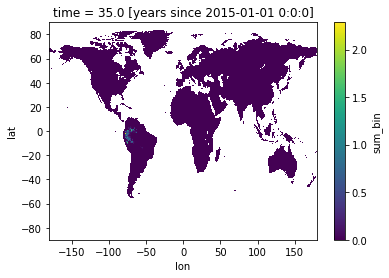

In [ ]:
da.sum_bin.plot()

In [37]:
for taxa in taxas:# Get all possible combinations of models and model_names    
    for model in models :
        for model_name in model_names:
            for bioscen_model_name in bioscen_model_names:
                for scenario in scenarios:
                    for l, ssprcp_short in enumerate(ssprcps_shorts):

                        convcodes = pd.read_csv("/storage/homefs/ch21o450/scripts/BioScenComb/data/IUCN_LUH_converion_table_Carlson.csv")
                        dir_habclass = "/storage/homefs/ch21o450/IUCN/Habitat_Classifications/" + taxa + "/"

                        dir_species = "/storage/workspaces/wa_climate/climate_trt/data/BioScen15/individual_projections/" + taxa+ "_" + model +"_results_climate/"
                        available_file = os.listdir(dir_species)
                        available_names = [x.split(".csv")[0] for x in available_file]

                        formatted_names = []

                        for species_name in available_names:
                            split_species_name = species_name.split("_")[:2]
                            formatted_species_name = " ".join(split_species_name)
                            formatted_names.append(formatted_species_name)

                        results = []
                        for i, species_name in enumerate(formatted_names[:2]):
                            formatted_species_name = species_name.replace(" ", "_")

                            for file_name in available_file:
                                if formatted_species_name in file_name and model + '_dispersal.csv.xz' in file_name:
                                    species_file = file_name
                                    species_file2 = [x.split(".csv")[0] for x in species_file] 
                                    break
                            else:
                                bioscen_species = None
                                continue

                            bioscen_species = pd.read_csv(dir_species + file_name)

                            available_files_iucn = formatted_species_name + ".csv"
                            if available_files_iucn in os.listdir(dir_habclass):
                                IUCN = pd.read_csv(dir_habclass + available_files_iucn)
                            else:
                                continue

                            lon = bioscen_species["x"]
                            lat = bioscen_species["y"]
                            z = bioscen_species[bioscen_model_name + '_' + scenario + '_' + selected_year]

                            df = pd.DataFrame({"lon": lon, "lat": lat, "vals": z})
                            df = df.fillna(0)
                            convcodes_renamed = convcodes.rename(columns={'IUCN_hab':'result.code'})
                            Habitats = IUCN.merge(convcodes_renamed, left_on='result.code', right_on='result.code')

                            keys = ['LUH1', 'LUH2', 'LUH3', 'LUH4', 'LUH5', 'LUH6', 'LUH7', 'LUH8','LUH9','LUH10', 'LUH11', 'LUH12']
                            split_cols = Habitats['LUH'].str.split('.', expand=True)
                            for i, key in enumerate(keys):
                                if i < len(split_cols.columns):
                                    Habitats[key] = split_cols[i]
                                else:
                                    Habitats[key] = pd.Series(dtype='float64')
                            if len(Habitats.columns) > len(keys) + 1:
                                num_missing_cols = len(Habitats.columns) - len(keys) - 1
                                Habitats = Habitats.reindex(columns=list(Habitats.columns) + ['LUH{}'.format(i) for i in range(13, 13 + num_missing_cols)], fill_value=np.nan)
                                Habitats.drop('LUH', axis=1, inplace=True)
                            Habitats_suitable = Habitats[Habitats['result.suitability'] == 'Suitable'].copy()

                            LandUseList = "/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_" + ssprcps_shorts[l] + ".nc"

                            #isimip = xr.open_dataarray("/storage/workspaces/wa_climate/climate_trt/data/ISIMIP/ISIMIP3b/InputData/GCM/global/miroc6_r1i1p1f1_w5e5_ssp585_tasmin_global_daily_2071_2080.nc")


                            ncfname = LandUseList
                            da_landuse =  xr.open_dataset(ncfname, decode_times=False)
                            da_landuse = da_landuse.isel(time=time)

                            #prifdf_bin = xr.where(prifdf > 0, 1, 0)
                            df_sdm =df

                            #build an empty np.array 
                            np_empty = np.zeros_like(da_landuse['primf'].values, dtype=float)

                            #isimip_lats = isimip['lat'].values
                            #isimip_lons = isimip['lon'].values

                            lats = da_landuse['lat'].values
                            lons = da_landuse['lon'].values

                            da_empty = xr.DataArray(np_empty, coords=[time, lats, lons], dims=['time','lats','lons'])
                            da_landclim = da_empty.assign_attrs(da_landuse)

                            keys = ["primn" if row[f"LUH{i}"] == "primn" else row[f"LUH{i}"] for _, row in Habitats_suitable.iterrows() for i in range(1, 5) if pd.notna(row[f"LUH{i}"])]
                            keys = list(set(keys))

                            # Compute the product with the "newvalue" column and assign it to a new column in the merged DataFrame
                            
                            # Compute the product with the "newvalue" column and assign it to a new column in the merged DataFrame
                            latitudes = df_sdm['lat'].unique()
                            longitudes = df_sdm['lon'].unique()

                            lats_sorted = np.sort(latitudes)
                            lons_sorted = np.sort(longitudes)

                            newvalue_array = np.zeros((len(lats_sorted), len(lons_sorted)))
                            for i, lat in enumerate(lats_sorted):
                                for j, lon in enumerate(lons_sorted):
                                    selection = df_sdm[(df_sdm['lat'] == lat) & (df_sdm['lon'] == lon)]
                                    if not selection.empty:
                                        newvalue_array[i, j] = selection['vals'].values[0]

                            da = xr.DataArray(newvalue_array, coords=[lats_sorted, lons_sorted], dims=['lat', 'lon'])
                            # Interpolate the values of newvalue to the dimensions of A
                            interpolated_values = da.interp(lat=lats, lon=lons)

                            # Add the interpolated values to the A DataArray
                            da_landuse['newvalue'] = interpolated_values
                            da_landuse['newvalue'] = interpolated_values.fillna(0)
                            for code in keys: 
                                # Compute the product with the LUH code and the "newvalue" column, and assign it to a new column in the merged DataFrame
                                np_empty = np.zeros_like(da_landuse[code].values, dtype=float)
                                da_landuse[f"{code}_bin"] = da_landuse[code] * da_landuse["newvalue"]

                                # Select the DataArrays ending in "_bin"
                                bin_arrays = [da_landuse[var] for var in da_landuse.data_vars if var.endswith("_bin")]

                                # Multiply all the arrays together
                                sum_bin = reduce(lambda x, y: x + y, bin_arrays)
                                # Assign the "product_bin" attribute to the da_landuse DataArray
                                da_landuse["sum_bin"] = sum_bin
                                difference = da_landuse["sum_bin"] - da_landuse["newvalue"]
                                da_landuse["difference_filter"] = difference

                                da_landclim = da_landclim.assign_attrs(da_landuse)

                                da_landuse.to_netcdf("/storage/homefs/ch21o450/scripts/BioScenComb/data/LandClim_Output/" + model+ "/" + taxa + "/" + model_name + "/" + scenario + "/" + formatted_species_name + "_" + str(time)+ ".nc")

